In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-mcyr56jw
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-mcyr56jw
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179812 sha256=142fa320d6ba2eead65ae1caf96726a3c378a1bce829577b0a9fef0e2ee0be98
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3udj3bc/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow

In [3]:
X = np.load('../content/images32_32.npy')
y = np.load('../content/labels32_32.npy')

In [4]:
test_size=0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7010, 32, 32, 3) (7010, 7)
(3005, 32, 32, 3) (3005, 7)


In [5]:
datagen = ImageDataGenerator(rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [6]:
datagen.fit(X_train)

In [7]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)      
  ]

In [8]:
histories = {}

In [9]:
img_height = 32
img_width = 32
channels = 3
img_shape = (img_height, img_width, channels)

In [10]:
# Create the base model with EfficientNetB1
base_model = tf.keras.applications.EfficientNetB1(input_shape=img_shape, include_top=False, weights='imagenet', pooling='max')

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [11]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [12]:
Normalizator_layer = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )

In [13]:
prediction_layer = keras.layers.Dense(7, activation='softmax')

In [14]:
model = tf.keras.Sequential([
  base_model,
  Normalizator_layer,
  keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu'),
  keras.layers.Dropout(rate=.45, seed=123),
  prediction_layer                           
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 7)                 1799      
                                                                 
Total params: 6,910,094
Trainable params: 332,295
Non-trainable params: 6,577,799
________________________________________

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adamax(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [17]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'), epochs=40, validation_data=datagen.flow(X_train, y_train, batch_size=8, subset='validation'))

Epoch 1/40
176/176 [==============================] - 34s 134ms/step - loss: 6.5077 - accuracy: 0.6316 - val_loss: 5.1639 - val_accuracy: 0.6669
Epoch 2/40
176/176 [==============================] - 22s 123ms/step - loss: 4.1942 - accuracy: 0.6651 - val_loss: 3.7097 - val_accuracy: 0.6669
Epoch 3/40
176/176 [==============================] - 27s 152ms/step - loss: 3.0408 - accuracy: 0.6673 - val_loss: 2.7379 - val_accuracy: 0.6683
Epoch 4/40
176/176 [==============================] - 22s 122ms/step - loss: 2.3597 - accuracy: 0.6703 - val_loss: 2.1813 - val_accuracy: 0.6683
Epoch 5/40
176/176 [==============================] - 21s 122ms/step - loss: 1.9479 - accuracy: 0.6714 - val_loss: 1.7752 - val_accuracy: 0.6683
Epoch 6/40
176/176 [==============================] - 21s 120ms/step - loss: 1.6877 - accuracy: 0.6728 - val_loss: 1.5767 - val_accuracy: 0.6705
Epoch 7/40
176/176 [==============================] - 21s 120ms/step - loss: 1.5364 - accuracy: 0.6735 - val_loss: 1.4041 - val_ac

In [18]:
histories['EfficientNetB1'] = history

(0.0, 1.0)

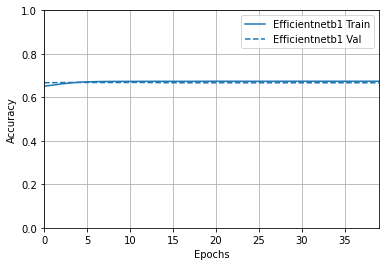

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0, 1])